In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical, Normal

import itertools

import sys
sys.path.insert(0, './../libraries/')

import partial_marginalization_lib as pm_lib
import galaxy_experiments_lib as galaxy_lib
import importance_sample_lib as imp_lib
import common_utils 

import sys
sys.path.insert(0, '../../../celeste_net/')
import celeste_net 

from celeste_net import OneGalaxyVAE


from datasets import Synthetic

# Load data

In [2]:
side_len = 31

In [3]:
galaxy_data = Synthetic(side_len, min_galaxies=1, max_galaxies=1, num_bands=5, num_images=50, 
                        brightness = 30000)

In [4]:
train_loader, test_loader = galaxy_lib.get_train_test_data(galaxy_data, batch_size=10)

In [5]:
for batch_idx, data in enumerate(train_loader):
    train_data_batch1 = data
    break
    
images_batch1 = train_data_batch1['image']
backgrounds_batch1 = train_data_batch1['background']

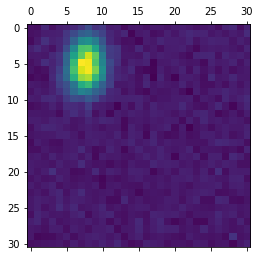

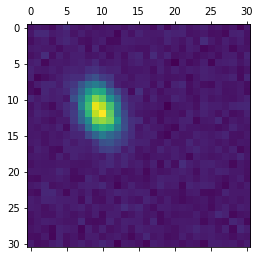

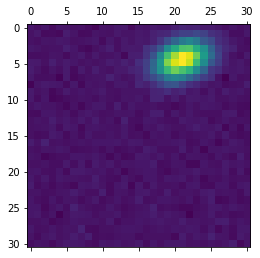

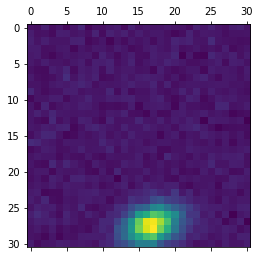

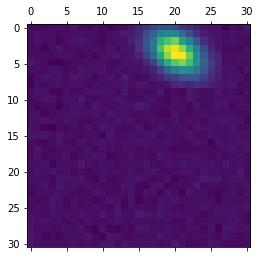

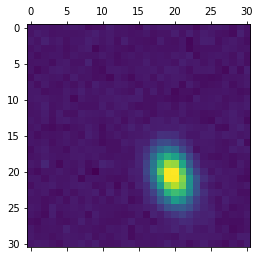

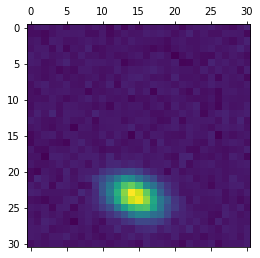

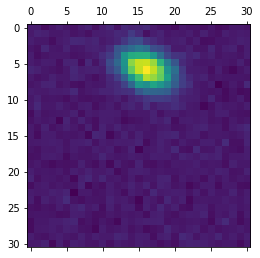

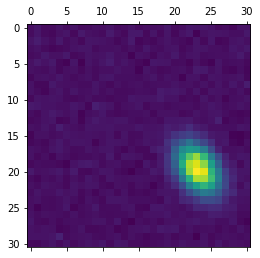

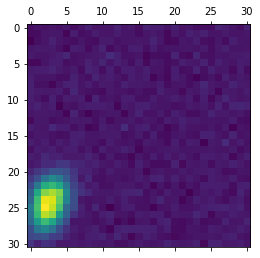

In [6]:
for i in range(images_batch1.shape[0]): 
    plt.matshow(images_batch1[i, 0, :, :])

In [7]:
imp_weights = imp_lib.get_importance_weights(images_batch1, attn_offset=4, prob_off=0.5)

# The VAE

In [8]:
galaxy_vae = celeste_net.OneGalaxyVAE(side_len)

In [9]:
# state_dict = torch.load("./galaxy_vae.dat", map_location='cpu')
# # state_dict = torch.load("../galaxy_results/test_epoch80.dat", map_location='cpu')

# galaxy_vae.load_state_dict(state_dict, strict=False)

galaxy_vae.eval(); 

In [10]:
galaxy_rnn = galaxy_lib.CelesteRNN(side_len, one_galaxy_vae=galaxy_vae)

In [11]:
pixel_probs = galaxy_rnn.get_pixel_probs(images_batch1, backgrounds_batch1)

In [12]:
map_pixel_loc = torch.argmax(pixel_probs, dim=1)

In [13]:
cond_loss, recon_mean, recon_var = galaxy_rnn.get_loss_conditional_a(
                                            resid_image = images_batch1 - backgrounds_batch1, 
                                            image_so_far = backgrounds_batch1, 
                                            var_so_far = backgrounds_batch1, 
                                            pixel_1d = map_pixel_loc)

In [14]:
map_pixel_loc

tensor([ 529,  529,  529,  529,  529,  529,  529,  529,  529,  529])

(array([529.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([4.33433568e-04, 4.83778970e-02, 9.63223604e-02, 1.44266824e-01,
        1.92211287e-01, 2.40155751e-01, 2.88100214e-01, 3.36044678e-01,
        3.83989141e-01, 4.31933605e-01, 4.79878068e-01]),
 <a list of 10 Patch objects>)

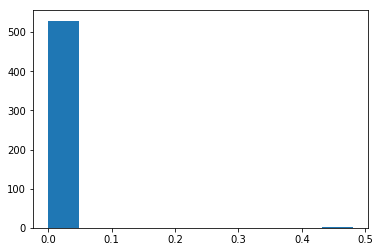

In [15]:
plt.hist(pixel_probs[0, :].detach())

In [16]:
recon_mean.sum()

tensor(3.3635e+07)

In [17]:
recon_var.sum()

tensor(3.3635e+07)

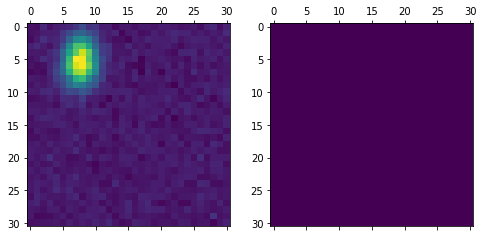

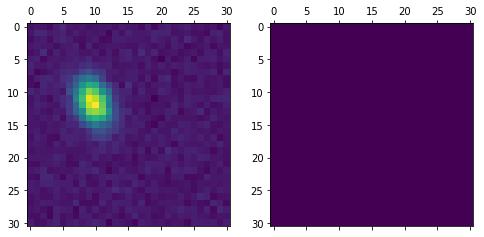

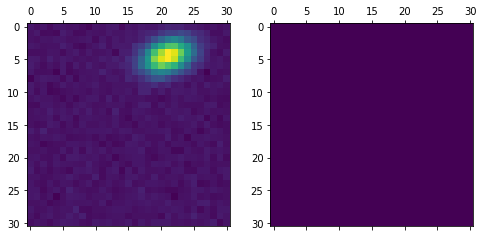

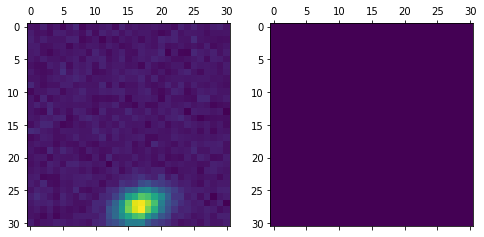

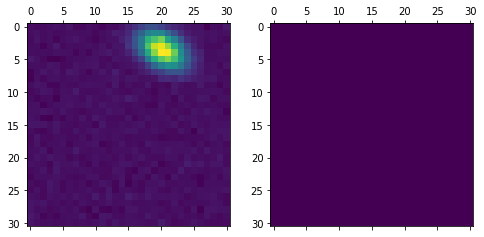

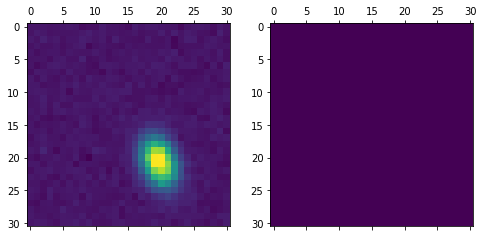

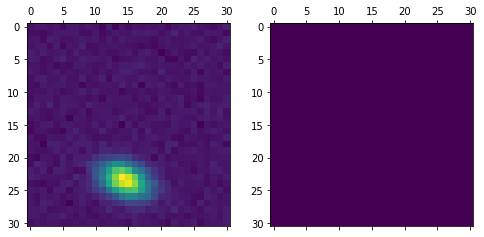

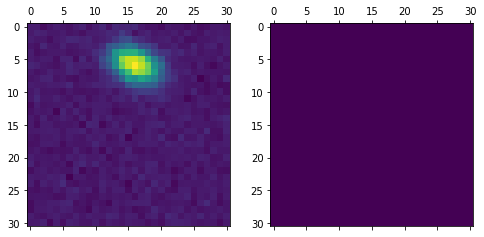

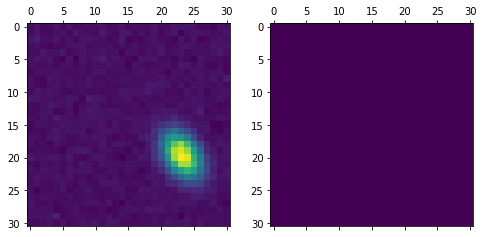

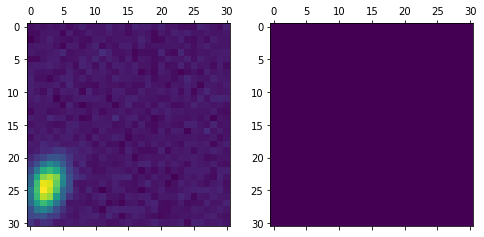

In [18]:
figsize = 8

for n in range(images_batch1.shape[0]): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(images_batch1[n, 0, :, :].squeeze())
    axarr[1].matshow(recon_mean.detach()[n, 0, :, :].squeeze())


# Experimenting with new importance sampling functions

In [19]:
# function to normalize image
attn_offset = galaxy_rnn.attn_offset
normalized_image = imp_lib.crop_and_normalize_image(images_batch1, attn_offset)

In [20]:
normalized_image.sum(dim = 1).sum(dim = 1) - 1

tensor(1.00000e-07 *
       [ 0.0000,  0.0000,  1.1921, -1.7881,  0.0000,  0.0000,  1.1921,
        -1.1921, -1.1921,  1.1921])

In [21]:
# append probability of being off
prob_off = pixel_probs.detach()[:, -1].view(-1, 1)
importance_weights = \
    imp_lib.get_importance_weights(images_batch1, attn_offset, prob_off)

In [22]:
np.max(np.abs(importance_weights.numpy().sum(1) - 1.0))

1.1920929e-07

In [23]:
print(np.abs(importance_weights.numpy().sum(1) - 1.0))

[0.0000000e+00 1.1920929e-07 0.0000000e+00 5.9604645e-08 0.0000000e+00
 5.9604645e-08 1.1920929e-07 1.1920929e-07 0.0000000e+00 0.0000000e+00]


In [24]:
assert np.max(np.abs(importance_weights[:, -1].numpy() - prob_off.numpy().squeeze())) < 1e-16
assert np.max(np.abs(importance_weights.numpy().sum(1) - 1.0)) < 1e-6

In [54]:
# visually check importance weights: 

In [55]:
prob_off = torch.zeros((images_batch1.shape[0], 1)) # pixel_probs.detach()[:, -1].view(-1, 1)
importance_weights = \
    imp_lib.get_importance_weights(images_batch1 - backgrounds_batch1, attn_offset, prob_off)

In [56]:
which_n = 1
image_sampled = torch.zeros((side_len, side_len))
for i in range(10000): 
    z_sample = common_utils.sample_class_weights(importance_weights)
    pixel_2d = galaxy_rnn.one_galaxy_vae.pixel_1d_to_2d(z_sample)
    image_sampled[pixel_2d[which_n, 0], pixel_2d[which_n, 1]] += 1

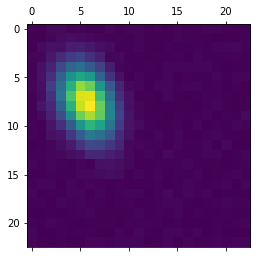

In [57]:
imp_weights_grid = importance_weights[:, 0:-1].view(images_batch1.shape[0], 23, 23)
plt.matshow(imp_weights_grid.detach()[which_n, :, :])

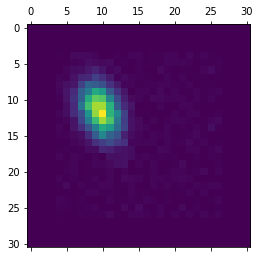

In [58]:
plt.matshow(image_sampled)

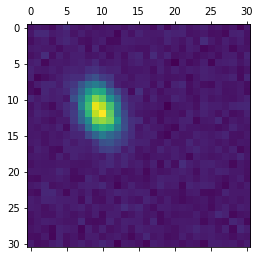

In [59]:
plt.matshow(images_batch1[which_n, 0, :, :])

In [30]:
# check optimizer goes through

In [31]:
optimizer = optim.Adam(galaxy_rnn.parameters(), lr=0.01, weight_decay=1e-6)
optimizer.zero_grad()

In [32]:
pm_loss, map_loss = imp_lib.importance_sampled_galaxy_loss(galaxy_rnn, images_batch1, backgrounds_batch1,
                                    backgrounds_batch1,
                                    use_importance_sample = True,
                                    use_baseline = True)

In [33]:
# check params
all_params = torch.zeros(1)

for f in galaxy_rnn.parameters():
    params = f.view(-1)
    all_params = torch.cat([params, all_params])

In [34]:
pm_loss

tensor(4.3403e+07)

In [35]:
map_loss

tensor(6.2114e+06)

In [36]:
pm_loss.backward()

In [37]:
optimizer.step()

In [38]:
_, map_loss2 = imp_lib.importance_sampled_galaxy_loss(galaxy_rnn, images_batch1, backgrounds_batch1,
                                    backgrounds_batch1,
                                    use_importance_sample = True,
                                    use_baseline = True)

In [39]:
map_loss2

tensor(6.2114e+06)

In [40]:
# check params
all_params2 = torch.zeros(1)

for f in galaxy_rnn.parameters():
    params = f.view(-1)
    all_params2 = torch.cat([params, all_params2])

In [41]:
torch.max(all_params2 - all_params)

tensor(1.00000e-02 *
       1.0000)

(array([867707.,   8771.,   3907.,   3551., 292787., 317484.,   3704.,
          3933.,   8877., 887800.]),
 array([-0.01000001, -0.008     , -0.006     , -0.004     , -0.002     ,
         0.        ,  0.002     ,  0.004     ,  0.006     ,  0.008     ,
         0.01000001]),
 <a list of 10 Patch objects>)

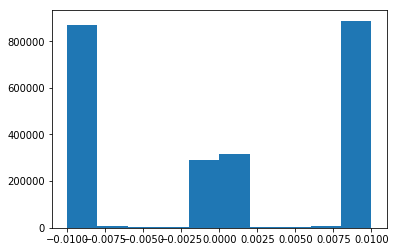

In [42]:
plt.hist((all_params2 - all_params).detach())

In [43]:
# Check train module

In [44]:
# train_module(vae, train_loader, test_loader, epochs,
#                         use_baseline = True,
#                         use_importance_sample = True,
#                         lr = 1e-4, weight_decay = 1e-6,
#                         save_every = 10,
#                         filename = './galaxy_vae_params',
#                         seed = 245345)

In [45]:
imp_lib.train_module(galaxy_rnn, train_loader, test_loader, 
                        epochs = 12, save_every = 2, 
                        use_baseline = True, 
                        use_importance_sample = True, 
                        lr = 1e-4, weight_decay = 1e-6,
                        filename = './test',
                        seed = 245345)

[0] loss: 3557094  	[0.7 seconds]
  * test loss: 4537808
writing the network's parameters to ./test_epoch0.dat
[1] loss: 3474439  	[0.8 seconds]
[2] loss: 3192430  	[0.9 seconds]
  * test loss: 4456145
writing the network's parameters to ./test_epoch2.dat
[3] loss: 2905026  	[0.7 seconds]
[4] loss: 2725719  	[0.8 seconds]
  * test loss: 1553412
writing the network's parameters to ./test_epoch4.dat
[5] loss: 2941008  	[0.7 seconds]
[6] loss: 2649866  	[0.8 seconds]
  * test loss: 3825326
writing the network's parameters to ./test_epoch6.dat
[7] loss: 1948569  	[0.8 seconds]
[8] loss: 3046830  	[0.8 seconds]
  * test loss: 2298796
writing the network's parameters to ./test_epoch8.dat
[9] loss: 3562969  	[0.7 seconds]
[10] loss: 2631878  	[0.8 seconds]
  * test loss: 3582881
writing the network's parameters to ./test_epoch10.dat
[11] loss: 2609298  	[0.9 seconds]


In [46]:
# check we can load it back

galaxy_vae_reload = celeste_net.OneGalaxyVAE(side_len)
state_dict = torch.load("./test_epoch10.dat", map_location='cpu')
galaxy_vae_reload.load_state_dict(state_dict, strict=False)

galaxy_vae_reload.eval(); 

In [47]:
galaxy_vae_reload

OneGalaxyVAE(
  (attn_enc): PixelAttention(
    (attn): Sequential(
      (0): Conv2d(10, 7, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): Conv2d(7, 7, kernel_size=(3, 3), stride=(1, 1))
      (3): ReLU()
      (4): Conv2d(7, 7, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): Conv2d(7, 1, kernel_size=(3, 3), stride=(1, 1))
      (7): Flatten()
      (8): Softmax()
    )
    (detect_none): Sequential(
      (0): Conv2d(10, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU()
      (2): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (4): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (5): ReLU()
      (6): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (8): Conv2d(16, 16, kernel_size=(3, 3), stri

In [49]:
np.load('./test_test_losses_array.npy')

array([4537808. , 4456145. , 1553412.5, 3825325.5, 2298795.8, 3582881.2],
      dtype=float32)